In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import time
import seaborn as sns

from statlearning import plot_regressions
from statlearning import plot_histogram
from statlearning import plot_feature_importance

from scipy import stats
from scipy.stats import norm, skew
# import statsmodels.api as sm
# import statsmodels.formula.api as smf


from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

import xgboost as xgb

warnings.filterwarnings("ignore")

In [2]:
tic = time.time()

sns.set_context('notebook')
sns.set_style('ticks')
crayon = ['#4E79A7', '#F28E2C', '#E15759', '#76B7B2', '#59A14F',
          '#EDC949', '#AF7AA1', '#FF9DA7', '#9C755F', '#BAB0AB']
sns.set_palette("pastel")
plt.rcParams['figure.figsize'] = (9, 6)
%matplotlib inline

In [3]:
df = pd.read_csv("NBA_Train.csv")
df

Train_ID     SALARY POSITION                    TEAM  Age  Games  \
0           1   2.489530       PF         Houston Rockets   22     76   
1           2   2.433333       PG               Utah Jazz   24     73   
2           3  20.158622       SF   Oklahoma City Thunder   25     81   
3           4  12.404495       PG         Houston Rockets   26     62   
4           5   1.500000       PG           Brooklyn Nets   21     48   
5           6   2.854940       PF              Miami Heat   33     46   
6           7   1.252440       SF         Detroit Pistons   22     43   
7           8   6.300000       PG           Brooklyn Nets   30     80   
8           9  15.514031       SG    New Orleans Pelicans   25     64   
9          10  12.000000       PG         Toronto Raptors   27     79   
10         11   3.553917       SF         Toronto Raptors   22     81   
11         12   6.270000       SG         Detroit Pistons   26     77   
12         13   4.440000       PF      Washington Wizards   28     69   
13         14  13.000000        C      Washington Wizards   31     53   
14         15   5.746479       SG           Atlanta Hawks   32     71   
15         16  15.851950       PG      Washington Wizards   23     82   
16         17   2.165160        C          Boston Celtics   22     70   
17         18   1.185784       SF           Brooklyn Nets   26     54   
18         19   4.236287       PG  Portland Trail Blazers   23     82   
19         20   9.756250        C           Atlanta Hawks   29     59   
20         21   2.380593       PF           Orlando Magic   24     76   
21         22  22.359364        C         Houston Rockets   28     71   
22         23   7.500000        C       San Antonio Spurs   31     79   
23         24   5.219169       SF      Los Angeles Lakers   28     64   
24         25   4.000000       PF         New York Knicks   22     78   
25         26   6.500000        C         Detroit Pistons   27     53   
26         27   7.448760        C           Chicago Bulls   33     60   
27         28   4.500000       SG           Chicago Bulls   33     82   
28         29   3.333333       PF           Atlanta Hawks   25     80   
29         30  15.592217        C      Los Angeles Lakers   27     81   
..        ...        ...      ...                     ...  ...    ...   
96         97   1.449187       SF        Sacramento Kings   33     56   
97         98   1.320000       SF    New Orleans Pelicans   26     65   
98         99   3.750000       PF         New York Knicks   23     69   
99        100   2.854940       SG           Chicago Bulls   33     73   
100       101   2.399040       PG         Milwaukee Bucks   22     70   
101       102  19.689000       PF     Cleveland Cavaliers   25     77   
102       103  12.403101       SF        Sacramento Kings   27     73   
103       104  13.500000        C       Charlotte Hornets   29     73   
104       105   1.015421       SG        Sacramento Kings   24     80   
105       106   4.500000       SF   Oklahoma City Thunder   25     82   
106       107   5.000000       PF          Boston Celtics   26     64   
107       108   5.613500       SF      Washington Wizards   27     78   
108       109   0.111444        C       Memphis Grizzlies   29     61   
109       110   5.000000       PF       Memphis Grizzlies   35     72   
110       111   2.038206       SF          Boston Celtics   22     62   
111       112  11.370786       PG   Golden State Warriors   25     78   
112       113   2.900000       PF         Toronto Raptors   33     82   
113       114   2.250000       PG           Chicago Bulls   29     72   
114       115   5.675000       SG       Charlotte Hornets   28     79   
115       116  12.000000       PG       Charlotte Hornets   23     73   
116       117   8.229375       SG         Houston Rockets   27     81   
117       118  16.407501       PG     Cleveland Cavaliers   21     71   
118       119   5.158539       SG       Memphis Grizzlies   32 

## Data Preprocessing

### Useless Columns

In [4]:
df.drop(columns="Train_ID", inplace=True)

### Missing value

In [5]:
df.isnull().sum()

SALARY      0
POSITION    0
TEAM        0
Age         0
Games       0
Minutes     0
PER         0
TS          0
ORB         0
DRB         0
TRB         0
AST         0
STL         0
BLK         0
TOV         0
USG         0
ORtg        0
DRtg        0
OWS         0
DWS         0
WS          0
dtype: int64

### Outliers

In [6]:
def _scatter(df, feature, target):
    """

    """
    # plt.figure(figsize=(16,8))
    plt.scatter(df[feature], df[target])
    plt.xlabel(feature)
    plt.ylabel(target)

    items = [feature, " vs ", target]
    title = ''.join(items)
    plt.title(title)


def subplot_scatter(df, target):
    """
    Plot scatter figures of each column in the dataFrame. 
    Args:
        df: pandas.DataFrame 
            DataFrame input.

        target: pandas.Series()
            Target column.


    """

    plt.figure(figsize=(30, 90))
    num_subplot = len(df.columns.drop(target))
    for i, col in enumerate(df.columns.drop(target)):
        plt.subplot(num_subplot//2 + 1, 2, i+1)
        _scatter(df, col, target)


def subplot_box(df):
    """

    """

    plt.figure(figsize=(30, 90))
    num_subplot = len(df.columns)
    for i, col in enumerate(df.columns):
        plt.subplot(num_subplot//2 + 1, 2, i+1)
        sns.set_palette("pastel")
        sns.boxplot(x=df[col])


def zscore_drop_missing(df, col_list, THRESHOLD=3):
    """
    
    """
    for col in col_list:
        z = np.abs(stats.zscore(df[col]))
        df = df[(z < THRESHOLD)]

    df.index = range(len(df))
    return df




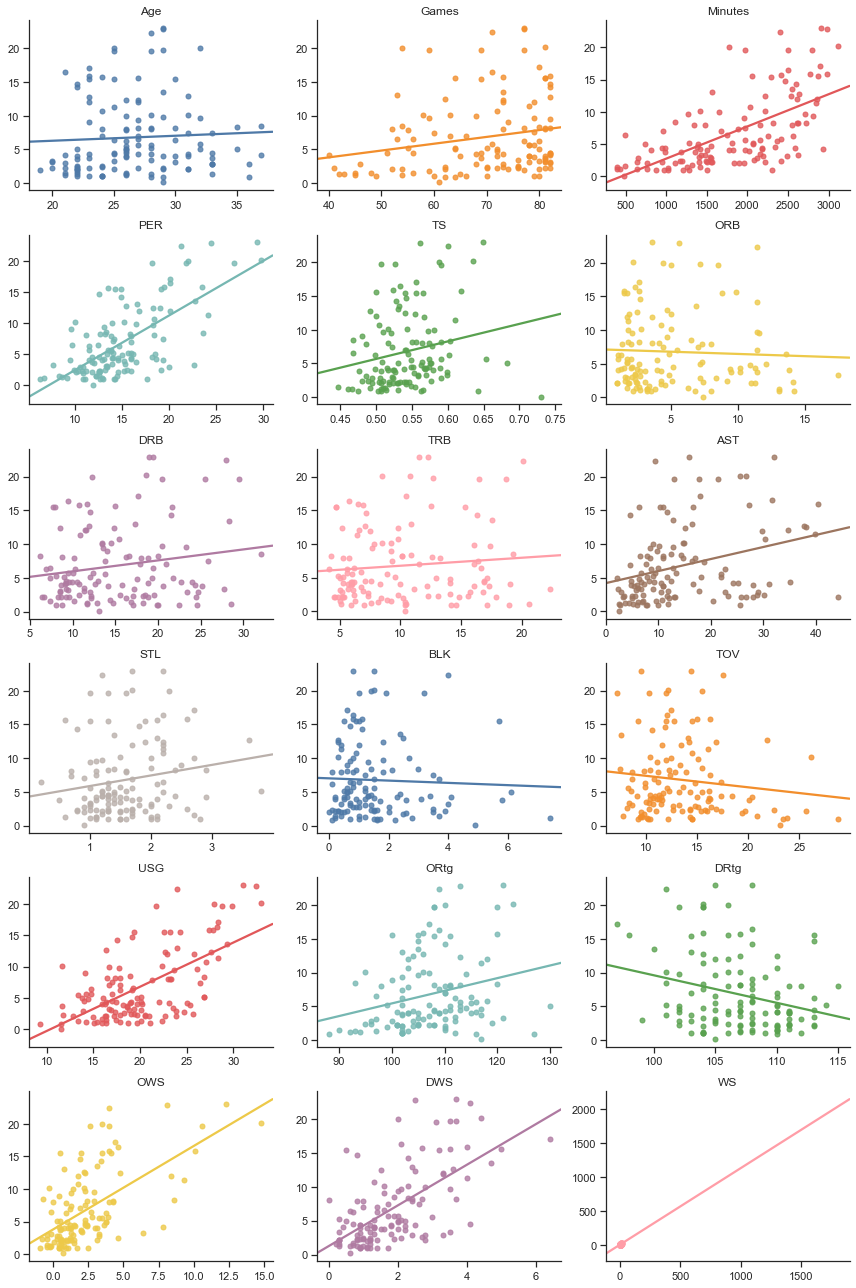

In [7]:
col_category = ["POSITION", "TEAM"]
col_number = df.columns.drop(["TEAM", "POSITION","SALARY"])
col_numbers = df.columns.drop(["TEAM", "POSITION"])

# subplot_scatter(df, "SALARY")

with sns.color_palette(crayon):
    plot_regressions(df[col_number], df["SALARY"])
    plt.show()

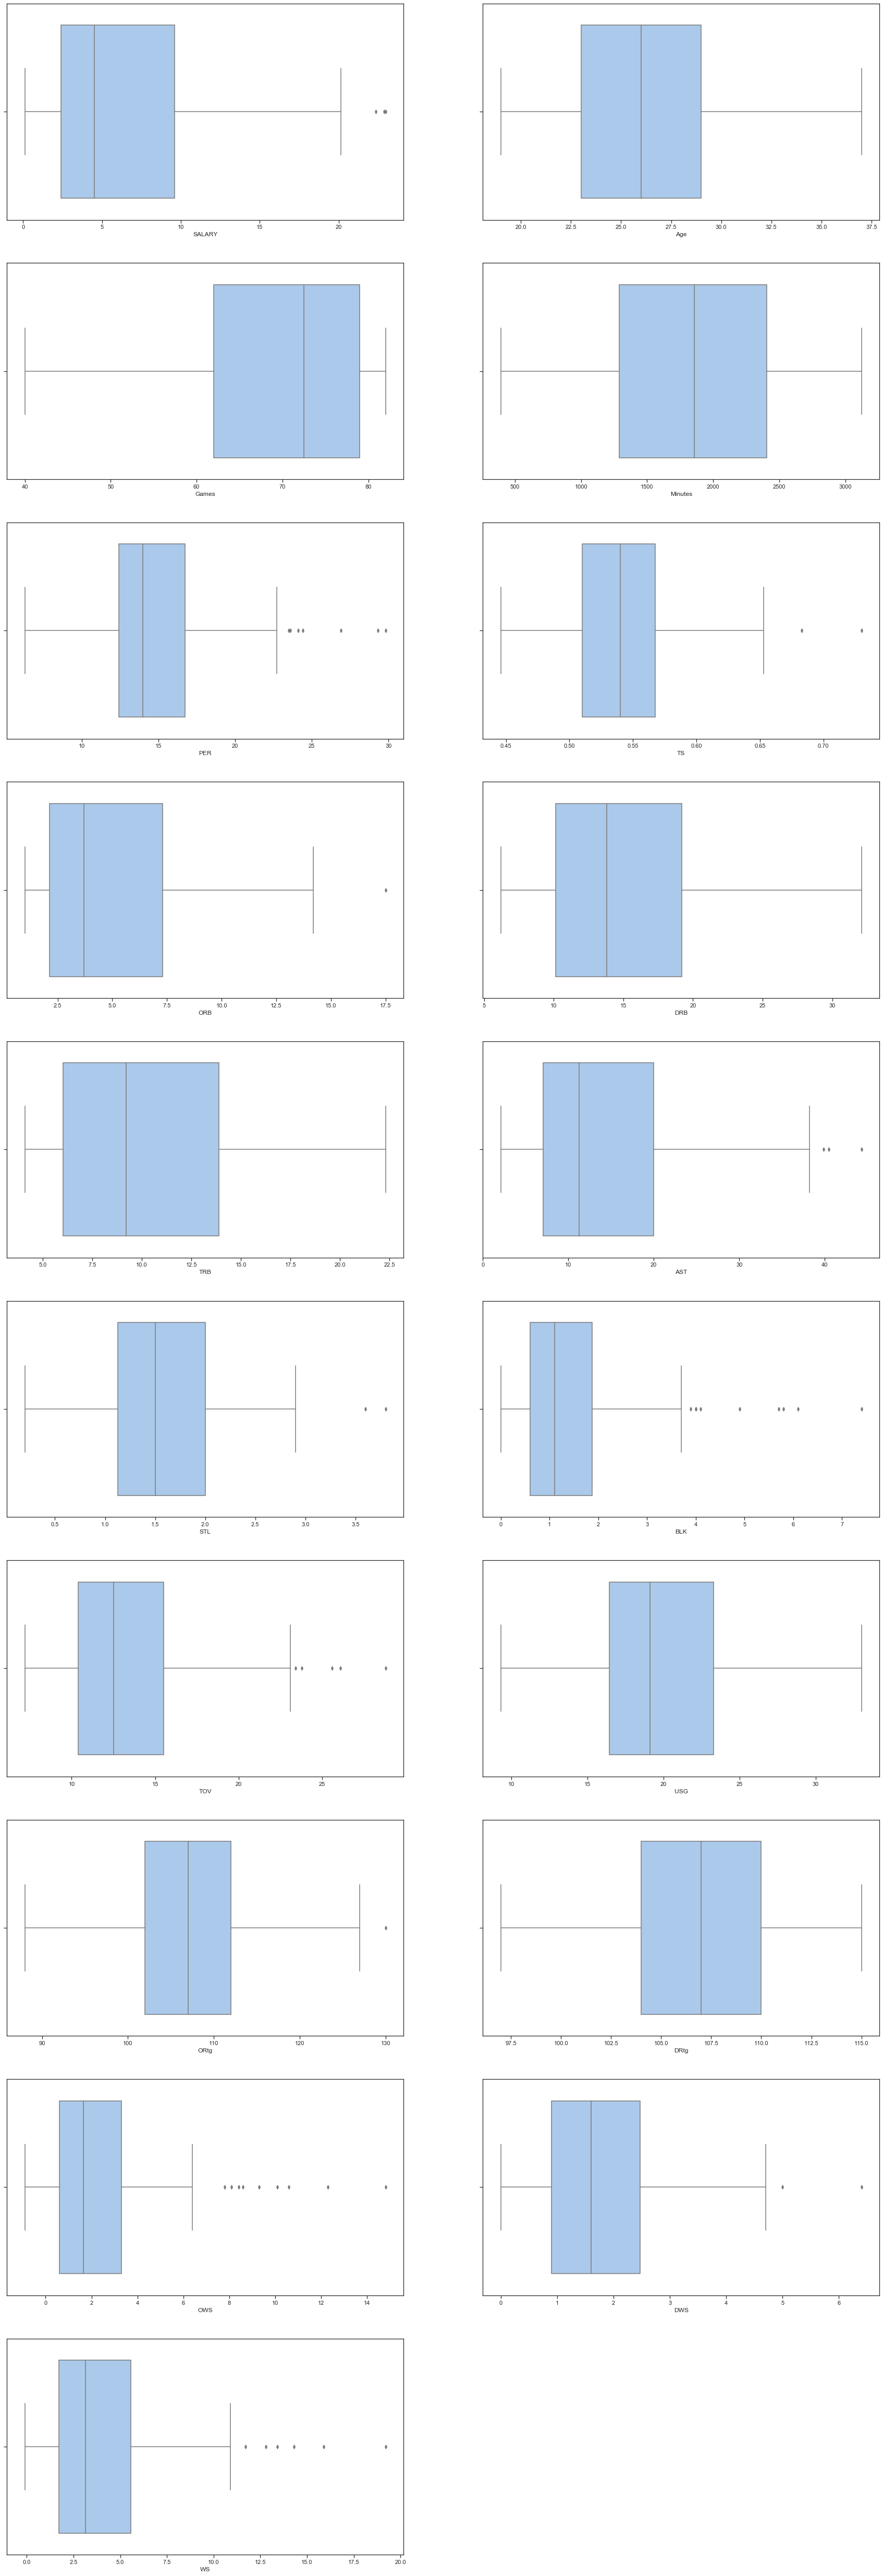

In [8]:
subplot_box(df[col_numbers])

In [9]:
#"SALARY"
df = zscore_drop_missing(df, [col_numbers], THRESHOLD=3.7)

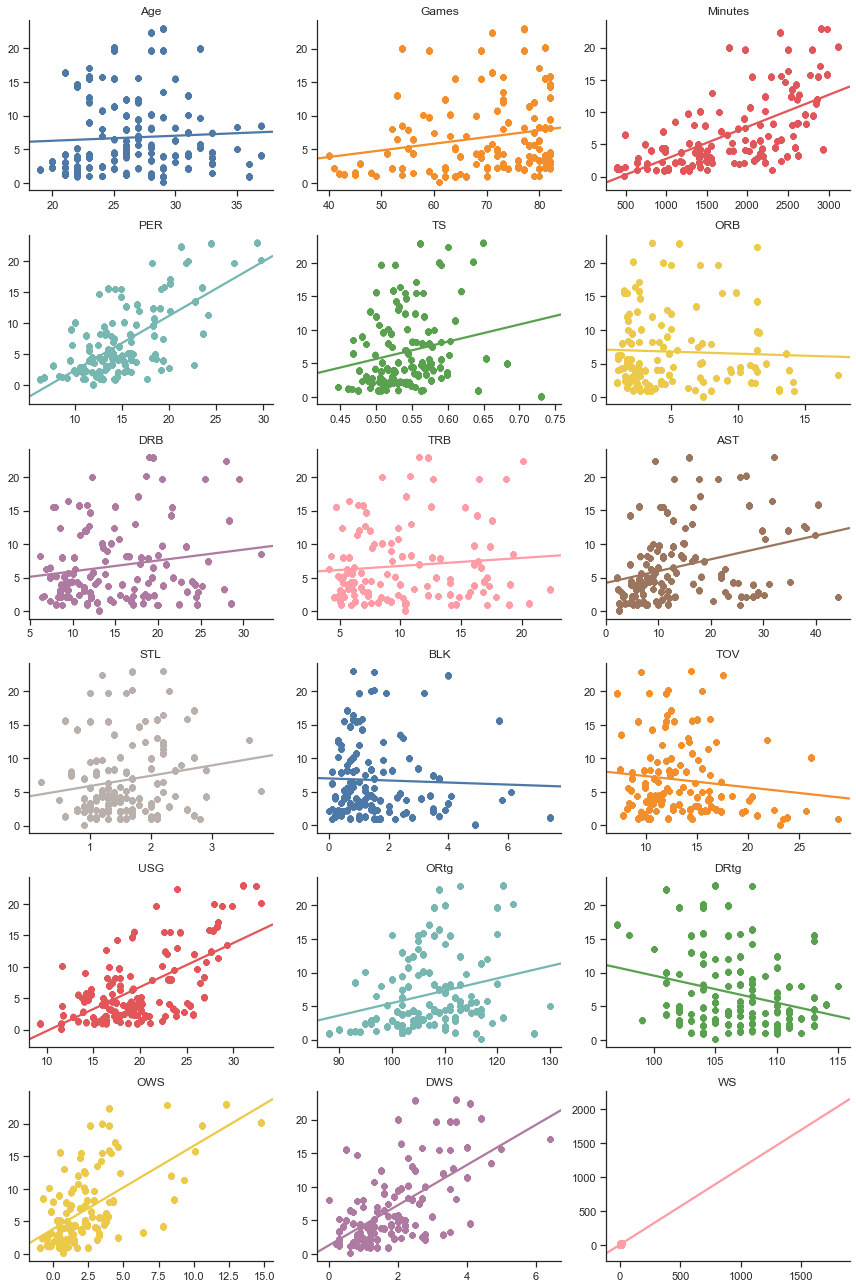

In [10]:
# subplot_scatter(df, "SALARY")
with sns.color_palette(crayon):
    plot_regressions(df[col_number], df["SALARY"])
    plt.show()

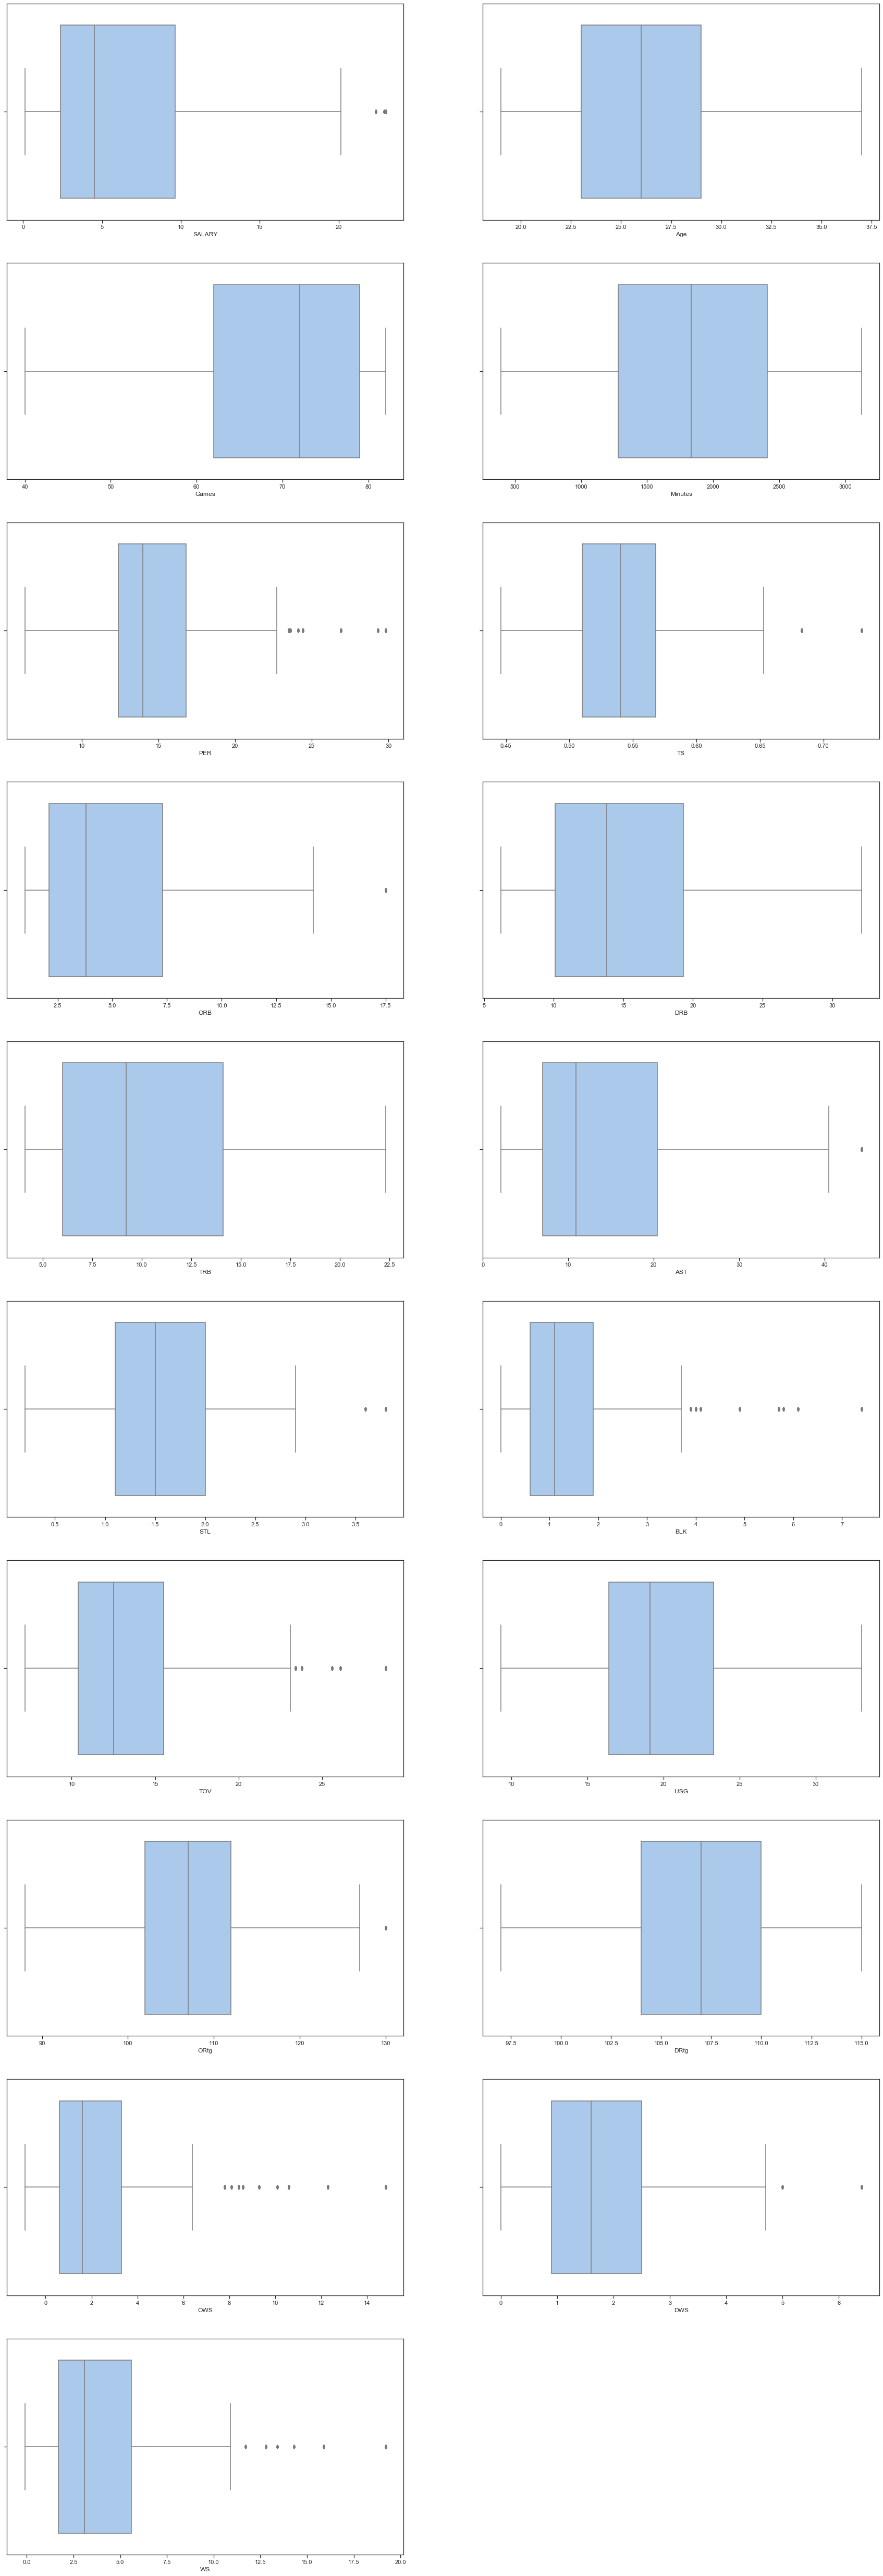

In [11]:
subplot_box(df[col_numbers])

### Normalization

In [12]:
normalized  = lambda x: (x - x.min()) * (1-0) / (x.max()-x.min())

normalized(df[col_number])

Age     Games   Minutes       PER        TS       ORB       DRB  \
0     0.166667  0.857143  0.617442  0.544681  0.461268  0.496970  0.474903   
1     0.166667  0.857143  0.617442  0.544681  0.461268  0.496970  0.474903   
2     0.166667  0.857143  0.617442  0.544681  0.461268  0.496970  0.474903   
3     0.166667  0.857143  0.617442  0.544681  0.461268  0.496970  0.474903   
4     0.166667  0.857143  0.617442  0.544681  0.461268  0.496970  0.474903   
5     0.166667  0.857143  0.617442  0.544681  0.461268  0.496970  0.474903   
6     0.166667  0.857143  0.617442  0.544681  0.461268  0.496970  0.474903   
7     0.166667  0.857143  0.617442  0.544681  0.461268  0.496970  0.474903   
8     0.166667  0.857143  0.617442  0.544681  0.461268  0.496970  0.474903   
9     0.166667  0.857143  0.617442  0.544681  0.461268  0.496970  0.474903   
10    0.166667  0.857143  0.617442  0.544681  0.461268  0.496970  0.474903   
11    0.166667  0.857143  0.617442  0.544681  0.461268  0.496970  0.474903   
12    0.166667  0.857143  0.617442  0.544681  0.461268  0.496970  0.474903   
13    0.166667  0.857143  0.617442  0.544681  0.461268  0.496970  0.474903   
14    0.166667  0.857143  0.617442  0.544681  0.461268  0.496970  0.474903   
15    0.166667  0.857143  0.617442  0.544681  0.461268  0.496970  0.474903   
16    0.166667  0.857143  0.617442  0.544681  0.461268  0.496970  0.474903   
17    0.166667  0.857143  0.617442  0.544681  0.461268  0.496970  0.474903   
18    0.166667  0.857143  0.617442  0.544681  0.461268  0.496970  0.474903   
19    0.277778  0.785714  0.401979  0.293617  0.225352  0.036364  0.173745   
20    0.277778  0.785714  0.401979  0.293617  0.225352  0.036364  0.173745   
21    0.277778  0.785714  0.401979  0.293617  0.225352  0.036364  0.173745   
22    0.277778  0.785714  0.401979  0.293617  0.225352  0.036364  0.173745   
23    0.277778  0.785714  0.401979  0.293617  0.225352  0.036364  0.173745   
24    0.277778  0.785714  0.401979  0.293617  0.225352  0.036364  0.173745   
25    0.277778  0.785714  0.401979  0.293617  0.225352  0.036364  0.173745   
26    0.277778  0.785714  0.401979  0.293617  0.225352  0.036364  0.173745   
27    0.277778  0.785714  0.401979  0.293617  0.225352  0.036364  0.173745   
28    0.277778  0.785714  0.401979  0.293617  0.225352  0.036364  0.173745   
29    0.277778  0.785714  0.401979  0.293617  0.225352  0.036364  0.173745   
...        ...       ...       ...       ...       ...       ...       ...   
2358  0.611111  1.000000  0.703188  0.293617  0.383803  0.157576  0.401544   
2359  0.611111  1.000000  0.703188  0.293617  0.383803  0.157576  0.401544   
2360  0.611111  1.000000  0.703188  0.293617  0.383803  0.157576  0.401544   
2361  0.611111  1.000000  0.703188  0.293617  0.383803  0.157576  0.401544   
2362  0.611111  1.000000  0.703188  0.293617  0.383803  0.157576  0.401544   
2363  0.611111  1.000000  0.703188  0.293617  0.383803  0.157576  0.401544   
2364  0.611111  1.000000  0.703188  0.293617  0.383803  0.157576  0.401544   
2365  0.611111  1.000000  0.703188  0.293617  0.383803  0.157576  0.401544   
2366  0.611111  1.000000  0.703188  0.293617  0.383803  0.157576  0.401544   
2367  0.611111  1.000000  0.703188  0.293617  0.383803  0.157576  0.401544   
2368  0.611111  1.000000  0.703188  0.293617  0.383803  0.157576  0.401544   
2369  0.277778  0.761905  0.599121  0.514894  0.204225  0.200000  0.355212   
2370  0.277778  0.761905  0.599121  0.514894  0.204225  0.200000  0.355212   
2371  0.277778  0.761905  0.599121  0.514894  0.204225  0.200000  0.355212   
2372  0.277778  0.761905  0.599121  0.514894  0.204225  0.200000  0.355212   
2373  0.277778  0.761905  0.599121  0.514894  0.204225  0.200000  0.355212   
2374  0.277778  0.761905  0.599121  0.514894  0.204225  0.200000  0.355212   
2375  0.277778  0.761905  0.599121  0.514894  0.204225  0.200000  0.355212   
2376  0.277778  0.761905  0.599121  0.514894  0.204225  0.200000  0.355212   
2377  0.277778  0.761905  0.59912

## Exploratory data analysis (EDA)

In [13]:
def get_status(x):
    return pd.DataFrame([x.count(), x.mean(), x.std(), x.min(), x.quantile(.25), x.quantile(.5), x.quantile(.75), x.max(), x.median(), x.mad(), x.var(), x.std(), x.skew(), x.kurt(), ],
                        index=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'median', 'mad', 'var', 'std', 'skew', 'kurt', ]).round(3)


def plot_distributed(series):
    
    sns.distplot(series, fit=norm, bins=10, color='cornflowerblue')
    (mu, sigma) = norm.fit(series)
    plt.legend(['Normal dist.($\mu=$ {:.2f} and $\sigma=${:.2f})'.format(
        mu, sigma)], loc='best')
    plt.ylabel('Frequency')
    plt.title('Distribution of '+series.name)

def subplot_distributed(df):
    """

    """
    plt.figure(figsize=(30, 90))
    num_subplot = len(df.columns)
    for i, col in enumerate(df.columns):
        plt.subplot(num_subplot//2 + 1, 2, i+1)
        sns.set_palette("pastel")
        
        plot_distributed(df[col])

def plot_prob(series):
    stats.probplot(series,plot=plt)
    

def subplot_prob(df):
    """

    """
    plt.figure(figsize=(30, 90))
    num_subplot = len(df.columns)
    for i, col in enumerate(df.columns):
        plt.subplot(num_subplot//2 + 1, 2, i+1)
        sns.set_palette("pastel")
        plot_prob(df[col])
        


### Target Variable

In [14]:
get_status(df["SALARY"])

0
count   2388.000
mean       6.767
std        5.604
min        0.111
25%        2.381
50%        4.500
75%        9.639
max       22.970
median     4.500
mad        4.507
var       31.402
std        5.604
skew       1.178
kurt       0.529

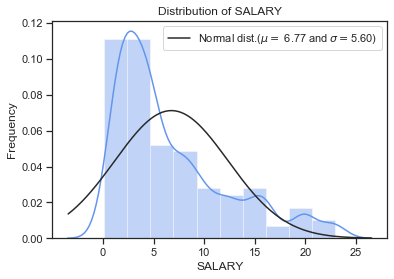

In [15]:
plot_distributed(df["SALARY"])

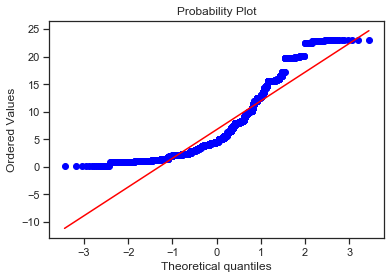

In [16]:
plot_prob(df["SALARY"])

In [17]:
get_status(df["SALARY"]**(1/3))

0
count   2388.000
mean       1.751
std        0.509
min        0.481
25%        1.335
50%        1.651
75%        2.128
max        2.843
median     1.651
mad        0.423
var        0.259
std        0.509
skew       0.286
kurt      -0.663

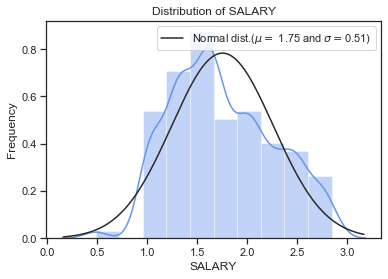

In [18]:
plot_distributed(df["SALARY"]**(1/3))

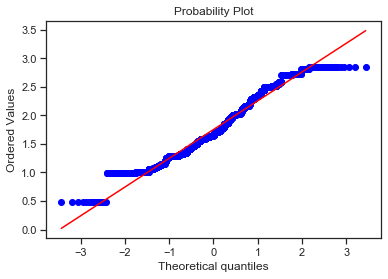

In [19]:
plot_prob(df["SALARY"]**(1/3))

### Numerical Variables

In [20]:
df_eda = normalized(df[col_number])
get_status(df_eda)

Age     Games   Minutes       PER        TS       ORB       DRB  \
count   2388.000  2388.000  2388.000  2388.000  2388.000  2388.000  2388.000   
mean       0.427     0.701     0.519     0.368     0.339     0.252     0.344   
std        0.226     0.271     0.256     0.181     0.160     0.231     0.231   
min        0.000     0.000     0.000     0.000     0.000     0.000     0.000   
25%        0.222     0.524     0.326     0.260     0.225     0.067     0.151   
50%        0.389     0.762     0.528     0.328     0.331     0.170     0.293   
75%        0.556     0.929     0.738     0.447     0.430     0.382     0.506   
max        1.000     1.000     1.000     1.000     1.000     1.000     1.000   
median     0.389     0.762     0.528     0.328     0.331     0.170     0.293   
mad        0.184     0.227     0.220     0.138     0.123     0.191     0.196   
var        0.051     0.073     0.066     0.033     0.025     0.053     0.054   
std        0.226     0.271     0.256     0.181     0.160     0.231     0.231   
skew       0.440    -0.800    -0.164     0.949     0.868     1.033     0.634   
kurt      -0.401    -0.380    -0.947     1.242     1.833     0.076    -0.422   

             TRB       AST       STL       BLK       TOV       USG      ORtg  \
count   2388.000  2388.000  2388.000  2388.000  2388.000  2388.000  2388.000   
mean       0.331     0.293     0.385     0.205     0.291     0.450     0.456   
std        0.253     0.232     0.171     0.182     0.191     0.208     0.180   
min        0.000     0.000     0.000     0.000     0.000     0.000     0.000   
25%        0.104     0.116     0.250     0.081     0.148     0.300     0.333   
50%        0.280     0.209     0.361     0.149     0.245     0.414     0.452   
75%        0.549     0.434     0.500     0.257     0.384     0.591     0.571   
max        1.000     1.000     1.000     1.000     1.000     1.000     1.000   
median     0.280     0.209     0.361     0.149     0.245     0.414     0.452   
mad        0.215     0.187     0.135     0.133     0.148     0.170     0.142   
var        0.064     0.054     0.029     0.033     0.037     0.043     0.032   
std        0.253     0.232     0.171     0.182     0.191     0.208     0.180   
skew       0.647     1.036     0.793     1.776     1.200     0.417     0.178   
kurt      -0.748     0.254     0.969     3.508     1.591    -0.384     0.192   

            DRtg       OWS       DWS        WS  
count   2388.000  2388.000  2388.000  2388.000  
mean       0.549     0.205     0.287     0.221  
std        0.204     0.166     0.183     0.174  
min        0.000     0.000     0.000     0.000  
25%        0.389     0.096     0.141     0.093  
50%        0.556     0.159     0.250     0.166  
75%        0.722     0.268     0.391     0.295  
max        1.000     1.000     1.000     1.000  
median     0.556     0.159     0.250     0.166  
mad        0.167     0.115     0.146     0.129  
var        0.041     0.027     0.033     0.030  
std        0.204     0.166     0.183     0.174  
skew      -0.144     2.087     0.967     1.676  
kurt      -0.479     5.444     0.922     3.506

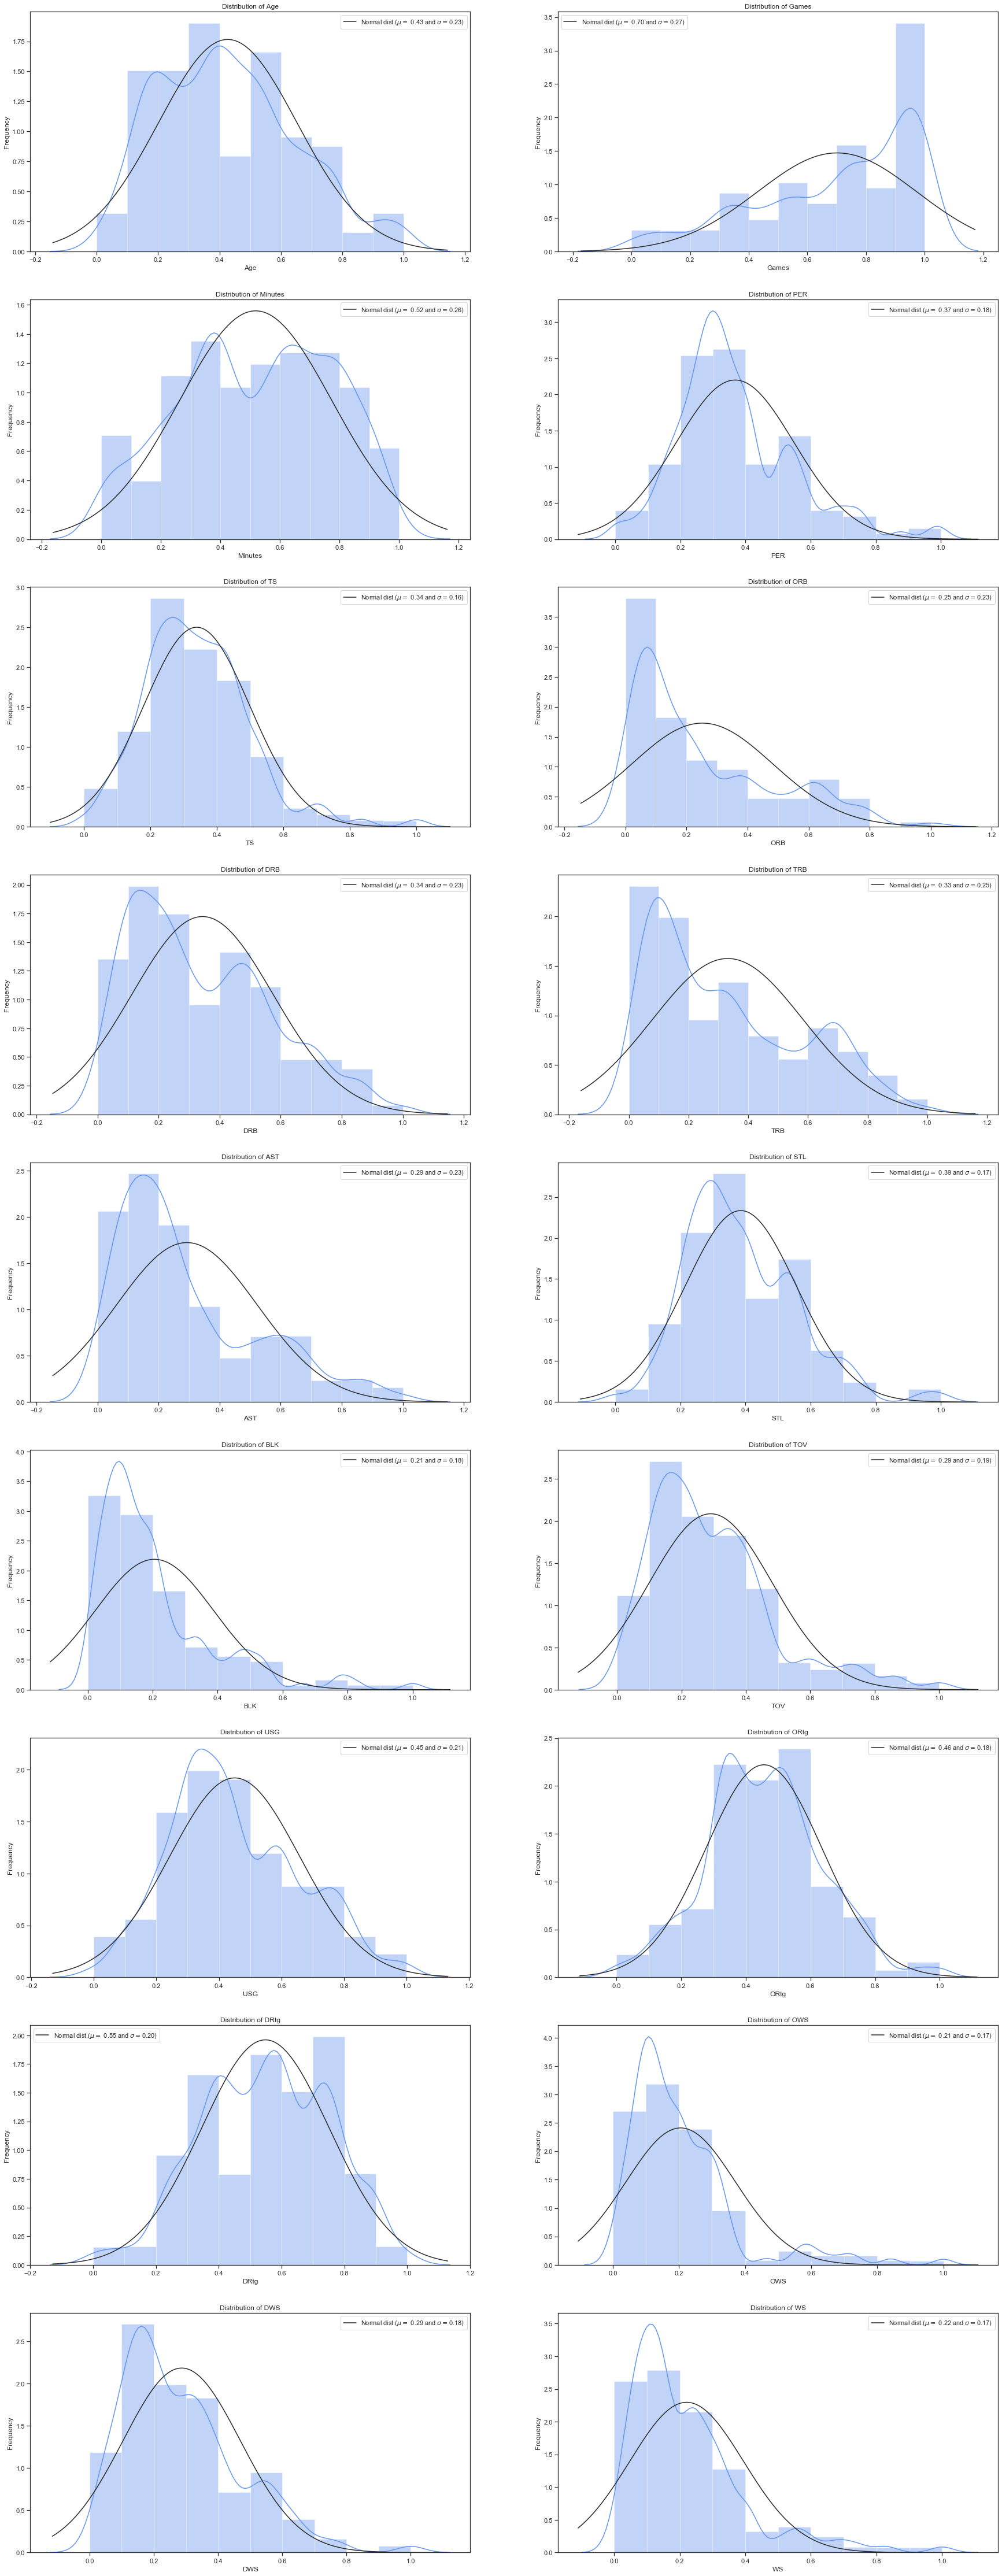

In [21]:
subplot_distributed(df_eda)

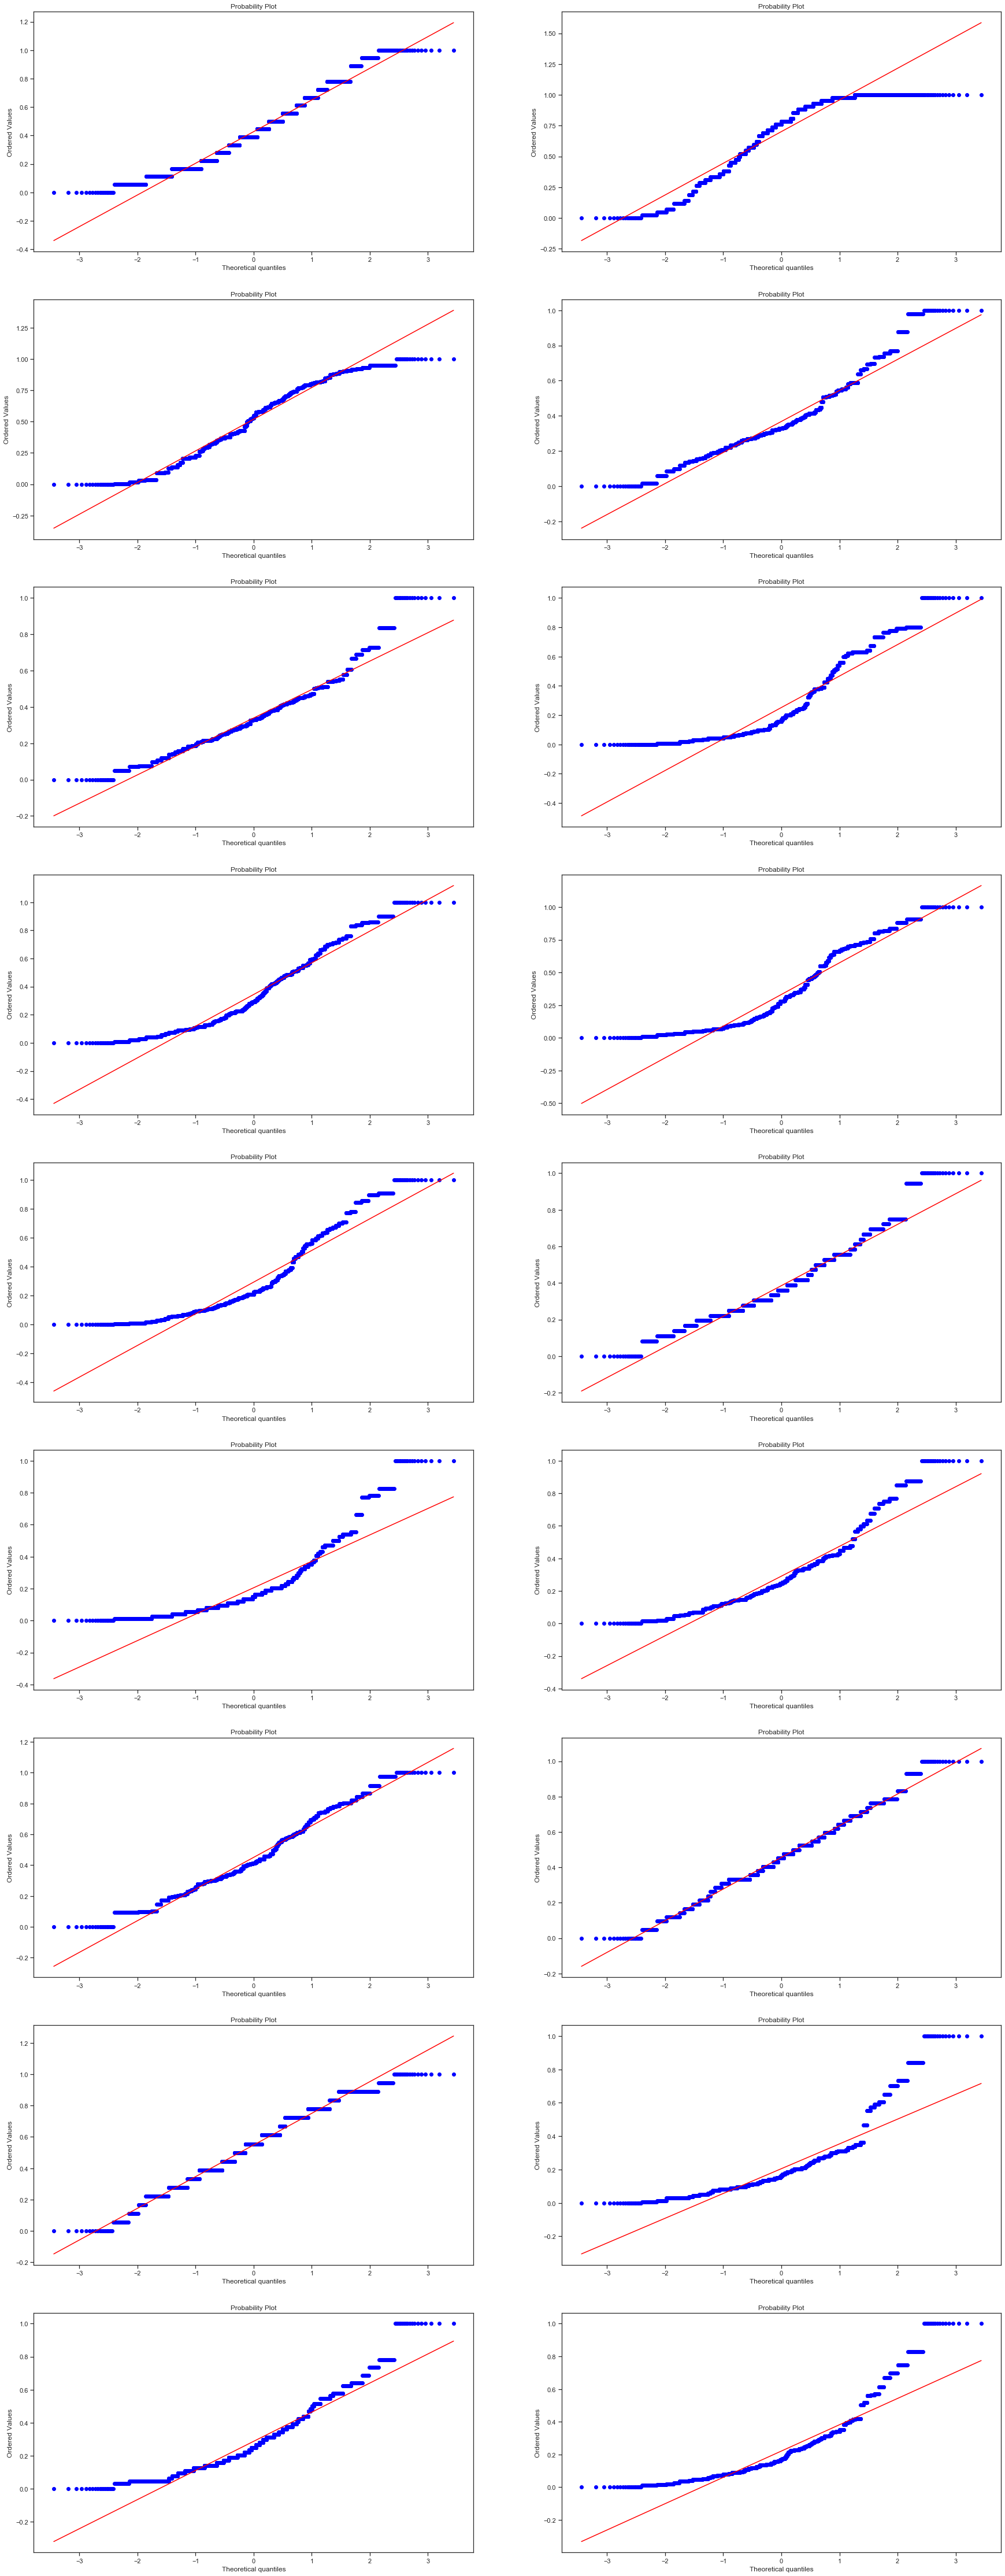

In [22]:
subplot_prob(df_eda)

In [23]:
skew_high_cols = ["BLK", "OWS", "WS"]
for col in skew_high_cols:
    df_eda[col] = df_eda[col] ** (1/3)

skew_medium_cols = ["PER", "TS", "ORB",
                    "DRB", "TRB", "AST", "STL", "TOV", "DWS"]
for col in skew_medium_cols:
    df_eda[col] = np.sqrt(df_eda[col])

skew_low_log = ["Games"]
for col in skew_low_log:
    df_eda[col] = df_eda[col] ** 2

In [24]:
get_status(df_eda)

Age     Games   Minutes       PER        TS       ORB       DRB  \
count   2388.000  2388.000  2388.000  2388.000  2388.000  2388.000  2388.000   
mean       0.427     0.565     0.519     0.587     0.565     0.446     0.548   
std        0.226     0.330     0.256     0.155     0.143     0.230     0.209   
min        0.000     0.000     0.000     0.000     0.000     0.000     0.000   
25%        0.222     0.274     0.326     0.509     0.475     0.258     0.388   
50%        0.389     0.580     0.528     0.572     0.575     0.412     0.542   
75%        0.556     0.862     0.738     0.668     0.655     0.618     0.711   
max        1.000     1.000     1.000     1.000     1.000     1.000     1.000   
median     0.389     0.580     0.528     0.572     0.575     0.412     0.542   
mad        0.184     0.289     0.220     0.115     0.110     0.194     0.176   
var        0.051     0.109     0.066     0.024     0.021     0.053     0.043   
std        0.226     0.330     0.256     0.155     0.143     0.230     0.209   
skew       0.440    -0.230    -0.164    -0.228    -0.340     0.369    -0.060   
kurt      -0.401    -1.324    -0.947     1.522     1.567    -0.837    -0.658   

             TRB       AST       STL       BLK       TOV       USG      ORtg  \
count   2388.000  2388.000  2388.000  2388.000  2388.000  2388.000  2388.000   
mean       0.528     0.496     0.604     0.543     0.509     0.450     0.456   
std        0.230     0.215     0.143     0.166     0.177     0.208     0.180   
min        0.000     0.000     0.000     0.000     0.000     0.000     0.000   
25%        0.323     0.341     0.500     0.433     0.385     0.300     0.333   
50%        0.529     0.457     0.601     0.530     0.495     0.414     0.452   
75%        0.741     0.659     0.707     0.636     0.620     0.591     0.571   
max        1.000     1.000     1.000     1.000     1.000     1.000     1.000   
median     0.529     0.457     0.601     0.530     0.495     0.414     0.452   
mad        0.198     0.174     0.111     0.129     0.140     0.170     0.142   
var        0.053     0.046     0.020     0.028     0.031     0.043     0.032   
std        0.230     0.215     0.143     0.166     0.177     0.208     0.180   
skew       0.098     0.243    -0.301     0.155     0.162     0.417     0.178   
kurt      -1.049    -0.483     1.801     0.406     0.246    -0.384     0.192   

            DRtg       OWS       DWS        WS  
count   2388.000  2388.000  2388.000  2388.000  
mean       0.549     0.552     0.507     0.565  
std        0.204     0.149     0.173     0.156  
min        0.000     0.000     0.000     0.000  
25%        0.389     0.457     0.375     0.453  
50%        0.556     0.542     0.500     0.549  
75%        0.722     0.644     0.625     0.666  
max        1.000     1.000     1.000     1.000  
median     0.556     0.542     0.500     0.549  
mad        0.167     0.113     0.141     0.123  
var        0.041     0.022     0.030     0.024  
std        0.204     0.149     0.173     0.156  
skew      -0.144     0.030     0.088    -0.061  
kurt      -0.479     1.504    -0.113     0.808

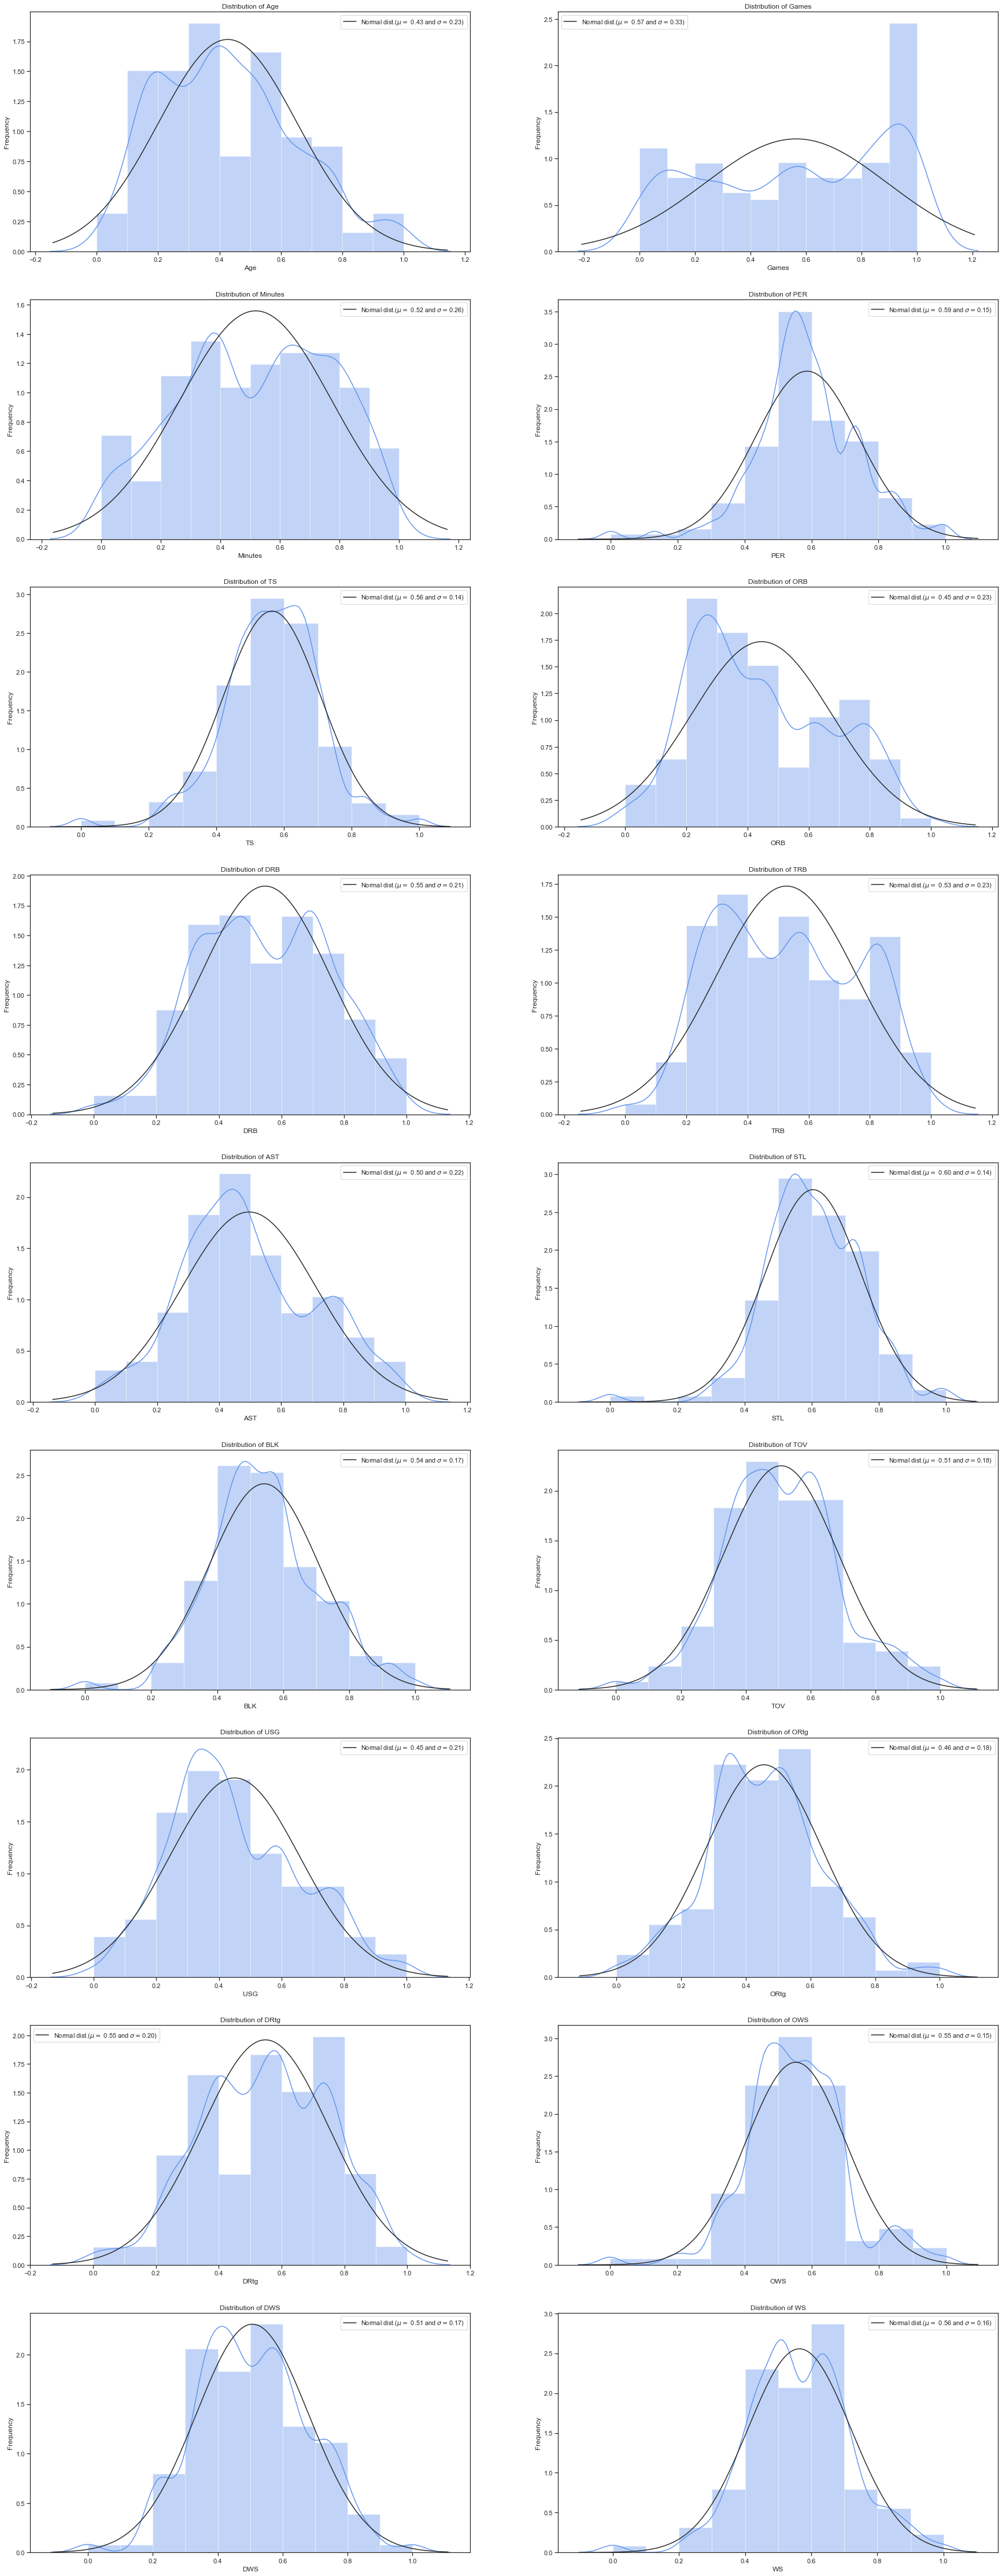

In [25]:
subplot_distributed(df_eda)

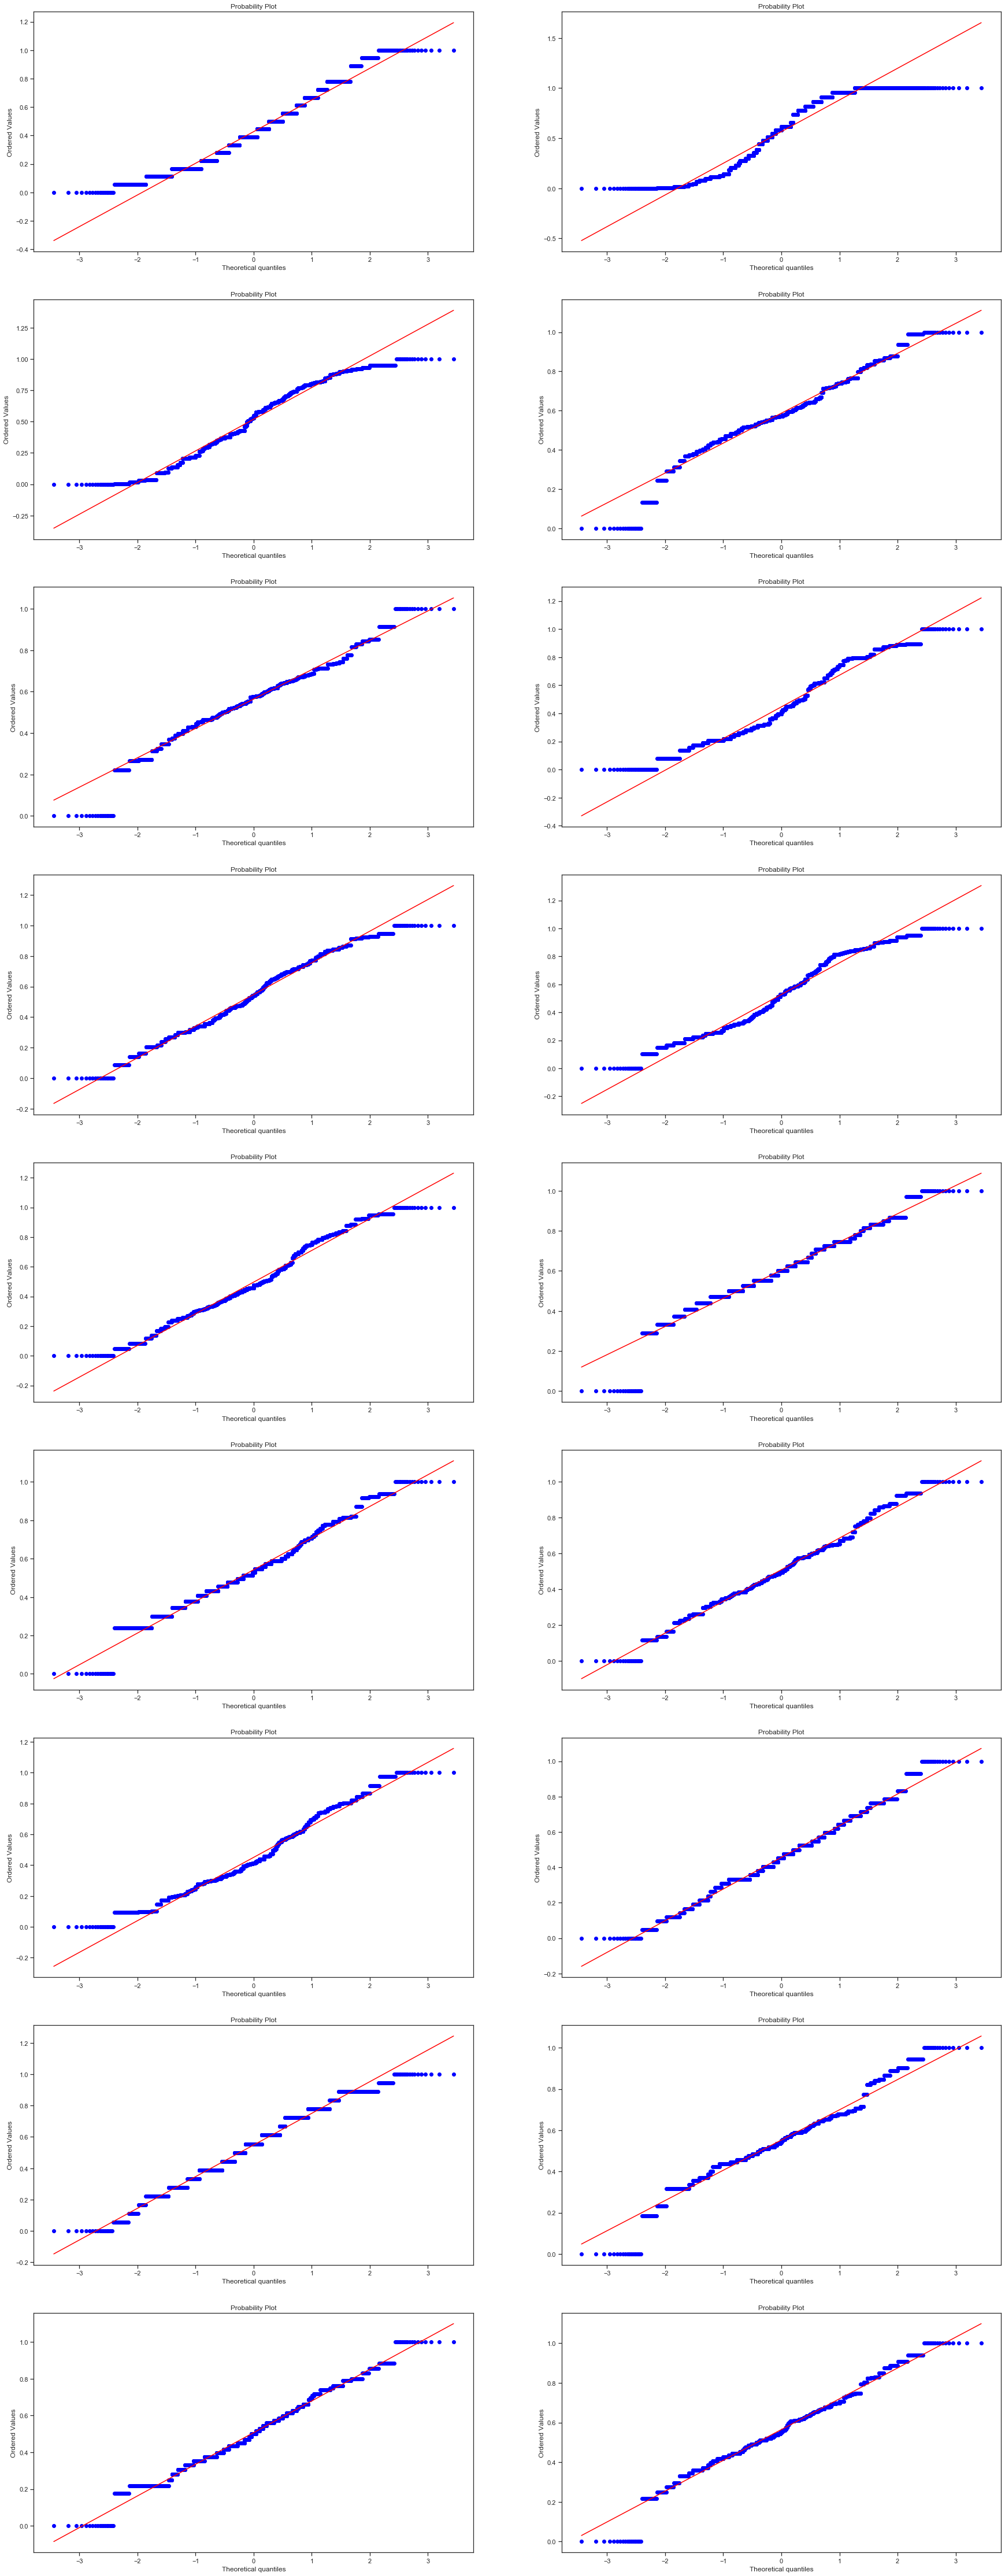

In [26]:
subplot_prob(df_eda)

Text(0.5, 1, 'Correlation Among Variables')

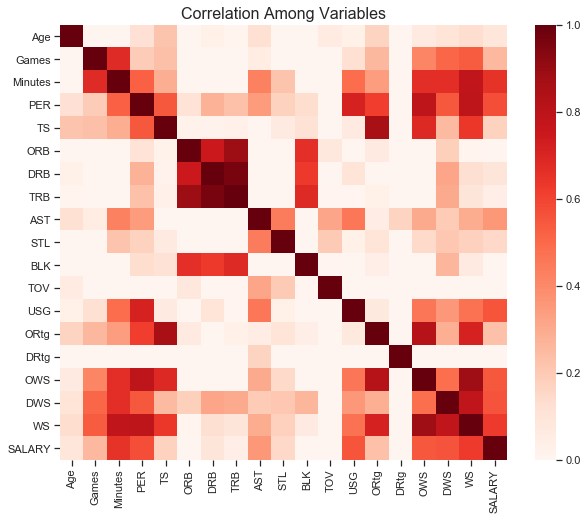

In [27]:
df_eda = pd.concat([df_eda,np.log(df["SALARY"])],axis=1)
plt.figure(figsize = (10,8))
sns.heatmap(df_eda.corr(), vmin = 0, vmax = 1, cmap = 'Reds')
plt.title('Correlation Among Variables', fontsize = 16)

In [28]:
print(abs(df_eda.corr()["SALARY"]).sort_values(ascending=False))

SALARY     1.000000
Minutes    0.656232
WS         0.627134
PER        0.576793
DWS        0.560762
USG        0.558463
OWS        0.548385
AST        0.361515
Games      0.255027
ORtg       0.232527
DRtg       0.191583
TS         0.174751
TOV        0.171684
STL        0.150007
DRB        0.095230
Age        0.092048
ORB        0.057372
BLK        0.052788
TRB        0.039462
Name: SALARY, dtype: float64


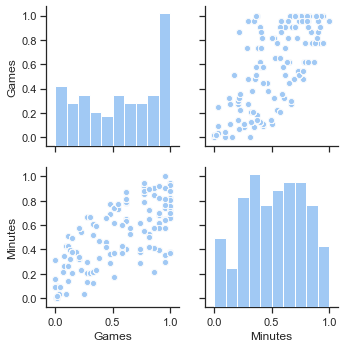

In [29]:
sns.pairplot(df_eda[["Games","Minutes"]])

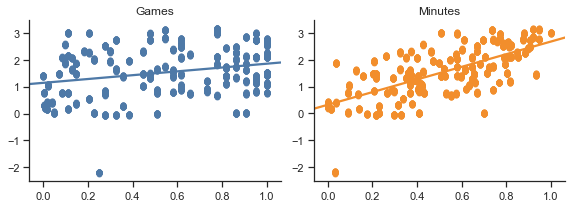

In [30]:
with sns.color_palette(crayon):
    plot_regressions(df_eda[["Games","Minutes"]], df_eda["SALARY"])
    plt.show()

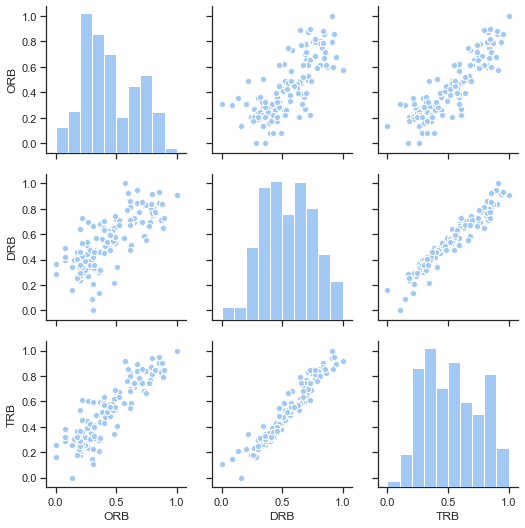

In [31]:
sns.pairplot(df_eda[["ORB","DRB","TRB"]])

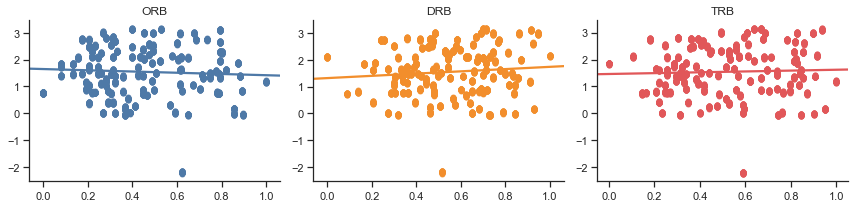

In [32]:
with sns.color_palette(crayon):
    plot_regressions(df_eda[["ORB","DRB","TRB"]], df_eda["SALARY"])
    plt.show()

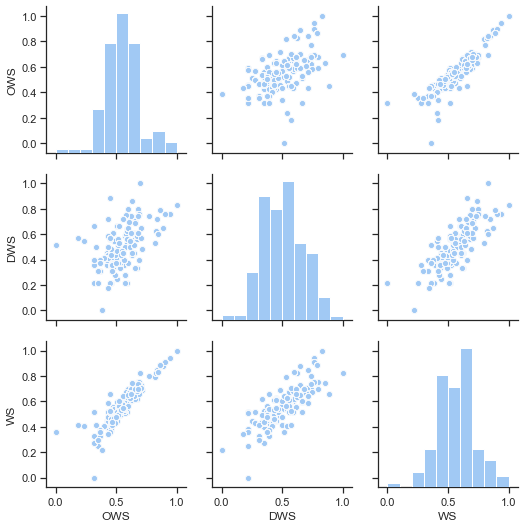

In [33]:
sns.pairplot(df_eda[["OWS","DWS","WS"]])

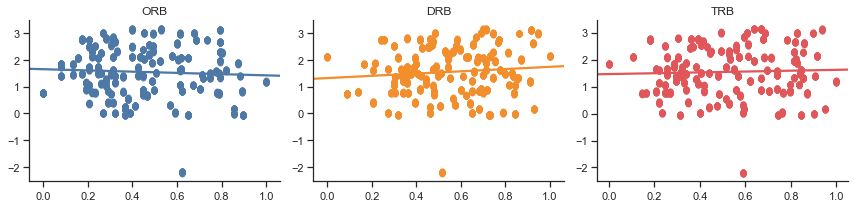

In [34]:
with sns.color_palette(crayon):
    plot_regressions(df_eda[["ORB","DRB","TRB"]], df_eda["SALARY"])
    plt.show()

### Category Variables

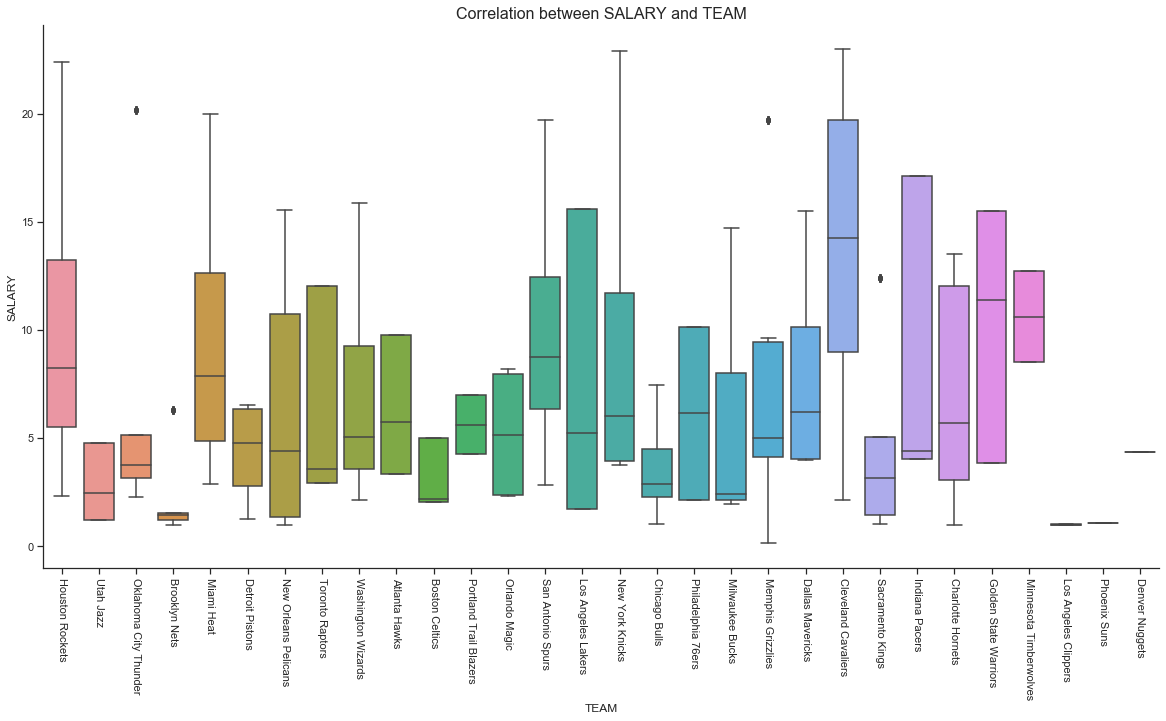

In [35]:
plt.figure(figsize=(20,10))
sns.set_palette("pastel")
sns.boxplot(x = 'TEAM', y = 'SALARY', data = df)
sns.despine()
plt.title('Correlation between SALARY and TEAM', fontsize = 16)
plt.xticks(rotation=270)
plt.show()

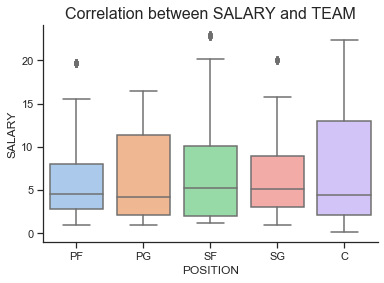

In [36]:
sns.set_palette("pastel")
sns.boxplot(x = 'POSITION', y = 'SALARY', data = df)
sns.despine()
plt.title('Correlation between SALARY and TEAM', fontsize = 16)
plt.show()

In [37]:
def fe_categorical_var(df, cols):
    d = pd.DataFrame()
    for col in cols:
        dummies = pd.get_dummies(
            df[col], prefix_sep="_", drop_first=True, prefix=col)
        #df.drop(columns=col, inplace=True)
        d = pd.concat([d, dummies], axis=1)

    return d


temp = pd.concat([fe_categorical_var(df, col_category),
                  df["SALARY"]], axis=1)

Text(0.5, 1, 'Correlation Among Variables')

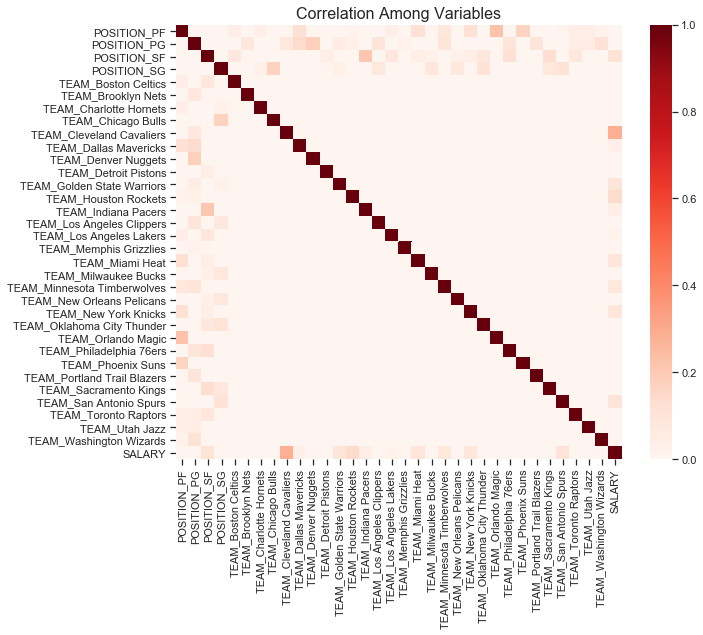

In [38]:
plt.figure(figsize=(10, 8))
sns.heatmap(temp.corr(), vmin=0, vmax=1, cmap='Reds')
plt.title('Correlation Among Variables', fontsize=16)

In [39]:
print(abs(temp.corr()["SALARY"]).sort_values(ascending=False))

SALARY                         1.000000
TEAM_Cleveland Cavaliers       0.287355
TEAM_Brooklyn Nets             0.184980
TEAM_Houston Rockets           0.140023
TEAM_Los Angeles Clippers      0.131312
TEAM_Chicago Bulls             0.114557
TEAM_Utah Jazz                 0.109071
POSITION_SF                    0.108241
TEAM_San Antonio Spurs         0.104648
TEAM_Boston Celtics            0.103249
TEAM_Golden State Warriors     0.096627
TEAM_New York Knicks           0.093500
TEAM_Miami Heat                0.092895
TEAM_Phoenix Suns              0.091625
TEAM_Minnesota Timberwolves    0.086998
TEAM_Detroit Pistons           0.079070
TEAM_Sacramento Kings          0.078453
POSITION_PF                    0.067733
POSITION_PG                    0.062260
TEAM_Orlando Magic             0.051019
TEAM_Indiana Pacers            0.043811
TEAM_Oklahoma City Thunder     0.040374
TEAM_Denver Nuggets            0.038715
TEAM_Dallas Mavericks          0.038532
TEAM_Milwaukee Bucks           0.033952


## Feature engineering

In [40]:

def fe_target_var(df):
#     return pd.DataFrame(np.log(df["SALARY"]))
#     return pd.DataFrame(df["SALARY"])
    return pd.DataFrame(df["SALARY"]**(1/3))

def fe_numerical_var(df):

    df_number = normalized(df[col_number])
    for col in skew_high_cols:
        df_eda[col] = df_eda[col]** (1/3)
    
    for col in skew_medium_cols:
        df_number[col] = np.sqrt(df_number[col])

    for col in skew_low_log:
        df_number[col] = df_number[col] ** 2

    df_number.drop(columns=["Games","TRB", "ORB",
                            "DWS", "OWS"], axis=1, inplace=True)

    return df_number




def fe_categorical_var(df, cols):
    d = pd.DataFrame()
    for col in cols:
        dummies = pd.get_dummies(
            df[col], prefix_sep="_", drop_first=True, prefix=col)
        #df.drop(columns=col, inplace=True)
        d = pd.concat([d, dummies], axis=1)

    return d


def feature_eng(df):
    return pd.concat(
        [fe_target_var(df), fe_numerical_var(df), fe_categorical_var(df, col_category)], axis=1)

In [41]:
df_engineered = feature_eng(df)
df_engineered

SALARY       Age   Minutes       PER        TS       DRB       AST  \
0     1.355311  0.166667  0.617442  0.738025  0.679167  0.689132  0.340755   
1     1.355311  0.166667  0.617442  0.738025  0.679167  0.689132  0.340755   
2     1.355311  0.166667  0.617442  0.738025  0.679167  0.689132  0.340755   
3     1.355311  0.166667  0.617442  0.738025  0.679167  0.689132  0.340755   
4     1.355311  0.166667  0.617442  0.738025  0.679167  0.689132  0.340755   
5     1.355311  0.166667  0.617442  0.738025  0.679167  0.689132  0.340755   
6     1.355311  0.166667  0.617442  0.738025  0.679167  0.689132  0.340755   
7     1.355311  0.166667  0.617442  0.738025  0.679167  0.689132  0.340755   
8     1.355311  0.166667  0.617442  0.738025  0.679167  0.689132  0.340755   
9     1.355311  0.166667  0.617442  0.738025  0.679167  0.689132  0.340755   
10    1.355311  0.166667  0.617442  0.738025  0.679167  0.689132  0.340755   
11    1.355311  0.166667  0.617442  0.738025  0.679167  0.689132  0.340755   
12    1.355311  0.166667  0.617442  0.738025  0.679167  0.689132  0.340755   
13    1.355311  0.166667  0.617442  0.738025  0.679167  0.689132  0.340755   
14    1.355311  0.166667  0.617442  0.738025  0.679167  0.689132  0.340755   
15    1.355311  0.166667  0.617442  0.738025  0.679167  0.689132  0.340755   
16    1.355311  0.166667  0.617442  0.738025  0.679167  0.689132  0.340755   
17    1.355311  0.166667  0.617442  0.738025  0.679167  0.689132  0.340755   
18    1.355311  0.166667  0.617442  0.738025  0.679167  0.689132  0.340755   
19    1.345036  0.277778  0.401979  0.541864  0.474713  0.416828  0.795425   
20    1.345036  0.277778  0.401979  0.541864  0.474713  0.416828  0.795425   
21    1.345036  0.277778  0.401979  0.541864  0.474713  0.416828  0.795425   
22    1.345036  0.277778  0.401979  0.541864  0.474713  0.416828  0.795425   
23    1.345036  0.277778  0.401979  0.541864  0.474713  0.416828  0.795425   
24    1.345036  0.277778  0.401979  0.541864  0.474713  0.416828  0.795425   
25    1.345036  0.277778  0.401979  0.541864  0.474713  0.416828  0.795425   
26    1.345036  0.277778  0.401979  0.541864  0.474713  0.416828  0.795425   
27    1.345036  0.277778  0.401979  0.541864  0.474713  0.416828  0.795425   
28    1.345036  0.277778  0.401979  0.541864  0.474713  0.416828  0.795425   
29    1.345036  0.277778  0.401979  0.541864  0.474713  0.416828  0.795425   
...        ...       ...       ...       ...       ...       ...       ...   
2358  2.015958  0.611111  0.703188  0.541864  0.619518  0.633675  0.319211   
2359  2.015958  0.611111  0.703188  0.541864  0.619518  0.633675  0.319211   
2360  2.015958  0.611111  0.703188  0.541864  0.619518  0.633675  0.319211   
2361  2.015958  0.611111  0.703188  0.541864  0.619518  0.633675  0.319211   
2362  2.015958  0.611111  0.703188  0.541864  0.619518  0.633675  0.319211   
2363  2.015958  0.611111  0.703188  0.541864  0.619518  0.633675  0.319211   
2364  2.015958  0.611111  0.703188  0.541864  0.619518  0.633675  0.319211   
2365  2.015958  0.611111  0.703188  0.541864  0.619518  0.633675  0.319211   
2366  2.015958  0.611111  0.703188  0.541864  0.619518  0.633675  0.319211   
2367  2.015958  0.611111  0.703188  0.541864  0.619518  0.633675  0.319211   
2368  2.015958  0.611111  0.703188  0.541864  0.619518  0.633675  0.319211   
2369  2.205947  0.277778  0.599121  0.717561  0.451913  0.595997  0.818912   
2370  2.205947  0.277778  0.599121  0.717561  0.451913  0.595997  0.818912   
2371  2.205947  0.277778  0.599121  0.717561  0.451913  0.595997  0.818912   
2372  2.205947  0.277778  0.599121  0.717561  0.451913  0.595997  0.818912   
2373  2.205947  0.277778  0.599121  0.717561  0.451913  0.595997  0.818912   
2374  2.205947  0.277778  0.599121  0.717561  0.451913  0.595997  0.818912   
2375  2.205947  0.277778  0.599121  0.717561  0.451913  0.595997  0.818912   
2376  2.205947  0.277778  0.599121  0.717561  0.451913  0.595997  0.818912   
2377  2.205947  0.277778  0.59

In [42]:
# selected_features = []

## Modelling

In [43]:
X_train = df_engineered.iloc[:,1:]
y_train = df_engineered["SALARY"]

In [44]:
# df_engineered.columns

In [45]:
df_test = feature_eng(pd.read_csv("NBA_Test.csv"))
df_test['TEAM_Houston Rockets'] = 0
df_test = df_test[df_engineered.columns]

X_test = df_test.iloc[:,1:]
y_test = df_test["SALARY"]

### Lasso

In [46]:
alpha = list(np.logspace(-4, -.5, 30))

lasso = LassoCV(cv=5, random_state=0, alphas=alpha)

lasso.fit(X_train, y_train)

LassoCV(alphas=[0.0001, 0.00013203517797162948, 0.00017433288221999874,
                0.00023018073130224678, 0.0003039195382313198,
                0.0004012807031942776, 0.0005298316906283707,
                0.0006995642156712634, 0.0009236708571873865,
                0.0012195704601594415, 0.0016102620275609393,
                0.0021261123338996556, 0.0028072162039411755,
                0.0037065129109221566, 0.004893900918477494,
                0.006461670787466...
                0.02592943797404667, 0.03423597957607583, 0.04520353656360245,
                0.05968456995122311, 0.07880462815669913, 0.10404983103657853,
                0.1373823795883264, 0.1813930693911063, 0.2395026619987486,
                0.31622776601683794],
        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=0, selection='cyclic', tol=0.0001,
        verbose=False)

In [47]:
lasso.alpha_

0.008531678524172814

In [48]:
lasso.coef_

array([ 0.        ,  0.85851582,  0.19345557,  0.        ,  0.        ,
        0.07094372,  0.        , -0.        ,  0.        ,  0.55821796,
        0.        , -0.21694936,  0.0401121 , -0.        , -0.0974351 ,
        0.        , -0.        ,  0.        , -0.00513863, -0.        ,
       -0.10263824,  0.08061526,  0.        , -0.        , -0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
       -0.        ,  0.        , -0.        ,  0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  0.        , -0.        ,
       -0.        , -0.06098309,  0.        , -0.        , -0.        ,
        0.        ])

In [49]:
y_pred = lasso.predict(X_test)

In [50]:
# np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))
# np.sqrt(mean_squared_error(y_test, y_pred))
np.sqrt(mean_squared_error(y_test ** 3, y_pred**3))

4.28943024369565

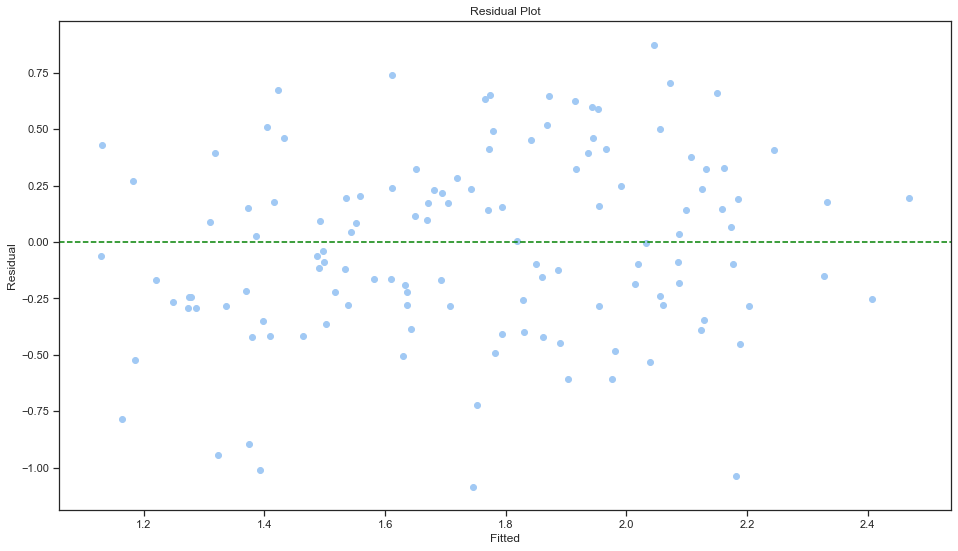

In [51]:
def plot_resid(y_test, y_pred):
    """

    """

    resid = y_test-y_pred

    plt.figure(figsize=(16, 9))
    plt.scatter(y_pred, resid)
    plt.axhline(0, 0, 1, color="g", ls="--")
    plt.xlabel("Fitted")
    plt.ylabel("Residual")
    plt.title("Residual Plot")
    plt.savefig("Residual plot ols")
    plt.show()


plot_resid(y_test, y_pred)

### Gradient Boosting

In [52]:
tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [250, 500, 750, 1000, 1500],
    'max_depth': [2, 3, 4],
    'subsample': [0.6, 0.8, 1.0]
}

# Using GridSearchCV would be too slow. Increase the number of iterations to explore more hyperparameter combinations.
gb = RandomizedSearchCV(GradientBoostingRegressor(
), tuning_parameters, n_iter=1, cv=10, return_train_score=False, n_jobs=4)
gb.fit(X_train, y_train)

y_pred = gb.predict(X_test)

print('Best parameters found by randomised search:', gb.best_params_, '\n')

Best parameters found by randomised search: {'subsample': 0.8, 'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.1} 



In [53]:
# np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))
# np.sqrt(mean_squared_error(y_test, y_pred))
np.sqrt(mean_squared_error(y_test ** 3, y_pred**3))

4.55779706799845

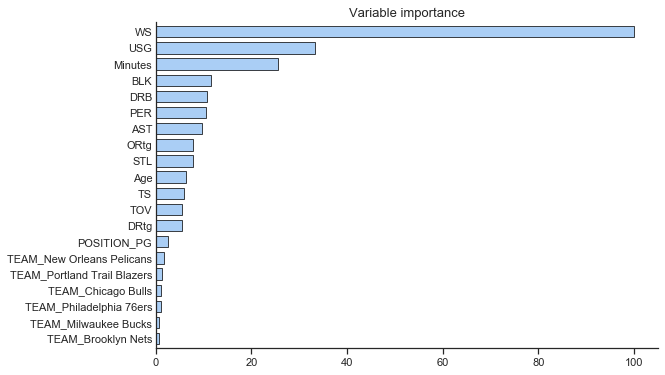

In [54]:
plot_feature_importance(gb.best_estimator_, list(X_train))
plt.show()

### RandomForestRegressor

In [55]:
tuning_parameters = {
    'min_samples_leaf': [1, 5, 10, 20, 50],
    'max_features': np.arange(1, X_train.shape[1], 5),
}

rf_search = RandomizedSearchCV(RandomForestRegressor(), tuning_parameters, cv=10, n_iter=20, return_train_score=True, n_jobs=4,
                               random_state=20)
rf_search.fit(X_train, y_train)

rf = rf_search.best_estimator_

print('Best parameters found by randomised search:', rf_search.best_params_, '\n')

y_pred = rf.predict(X_test)

np.sqrt(mean_squared_error(y_test ** 3, y_pred**3))



Best parameters found by randomised search: {'min_samples_leaf': 20, 'max_features': 11} 



4.109711727306096

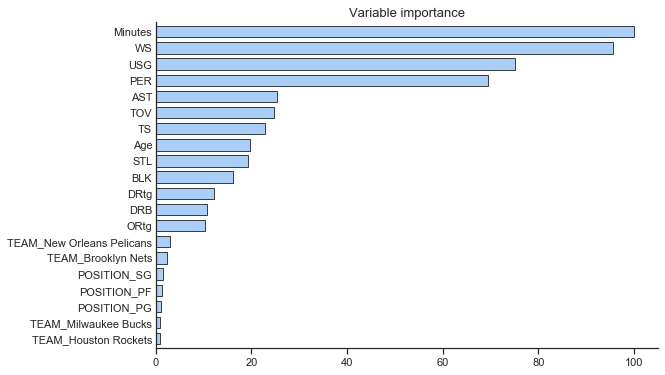

In [56]:
plot_feature_importance(rf_search.best_estimator_, list(X_train))
plt.show()

### Xgboost

In [57]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
reg_xgb = GridSearchCV(xgb_model,
                       {'max_depth': [2, 4, 6],
                        'n_estimators': [50, 100, 200]}, verbose=1)
reg_xgb.fit(X_train, y_train)

print(reg_xgb.best_score_)

print('Best parameters found by randomised search:', reg_xgb.best_params_, '\n')

y_pred = reg_xgb.predict(X_test)

np.sqrt(mean_squared_error(y_test ** 3, y_pred**3))

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   13.5s finished


0.42044555766720865
Best parameters found by randomised search: {'max_depth': 2, 'n_estimators': 50} 



4.0281166385716425

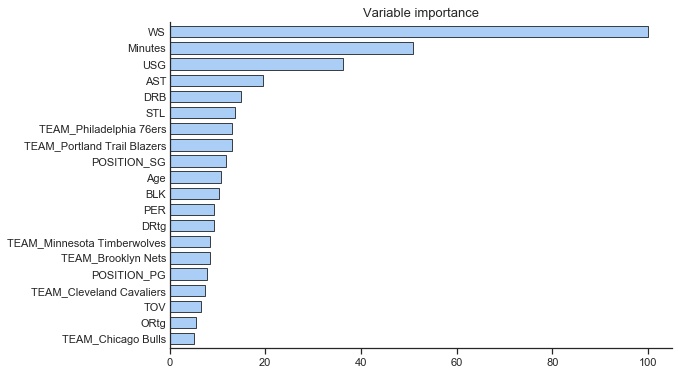

In [58]:
plot_feature_importance(reg_xgb.best_estimator_, list(X_train))
plt.show()

In [59]:
toc = time.time()
print("Training time: {0:.4f}s".format(toc - tic))

Training time: 64.5048s
